##Import dependencies

In [ ]:
!pip install focal_loss

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from focal_loss import BinaryFocalLoss

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


## Load dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/CVC-ClinicDB/"
image_folder = BASE_PATH + "imagesTr/"
mask_folder = BASE_PATH + "labelsTr/"

Load path names

In [ ]:
# Define a sorting key function
def sort_key(file_path):
    # Extract the numeric part of the file name
    file_name = file_path.split('/')[-1]  # Get the last part of the path
    numeric_part = file_name.split('_')[0]  # Get the part before the underscore
    return int(numeric_part)  # Convert to integer for sorting

def sort_mask_key(file_path):
  # Extract the numeric part of the file name
    file_name = file_path.split('/')[-1]  # Get the last part of the path
    numeric_part = file_name.split('.')[0]  # Get the part before the underscore
    return int(numeric_part)  # Convert to integer for sorting

In [ ]:
images = sorted(glob(os.path.join(image_folder + "*.tif")), key = sort_key)
masks = sorted(glob(os.path.join(mask_folder + "*.tif")), key = sort_mask_key)

n_images = len(images)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state = 42)

Load dataset

In [ ]:
def read_image(path):
    # path = path.decode()  # Convert bytes to string
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return image

def read_mask(path):
    # path = path.decode()  # Convert bytes to string
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        image = read_image(x)
        mask = read_mask(y)
        return image, mask

    image, mask = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


In [ ]:
mask = cv2.imread(X_test[0], cv2.IMREAD_GRAYSCALE)

In [ ]:
def get_dataset(x_path, y_path):
  X = np.empty((len(x_path), 256, 256, 3))
  y = np.empty((len(y_path), 256, 256, 1))
  for i, path in enumerate(x_path):
    image = read_image(x_path[i])
    mask = read_mask(y_path[i])
    # image.set_shape([256, 256, 3])
    # mask.set_shape([256, 256, 1])
    X[i, ], y[i, ] = image, mask

  return X, y

In [ ]:
X_arr, y_arr = get_dataset(X_test, y_test)

In [ ]:
X_arr.shape

(62, 256, 256, 3)

In [ ]:
y_arr.shape

(62, 256, 256, 1)

In [ ]:
train_dataset = tf_dataset(X_train, y_train)
val_dataset = tf_dataset(X_val, y_val)


##Visualisation

In [ ]:
# count = 0
# i = 0
# fig,axs = plt.subplots(12,3, figsize=(20,50))
# for image in images:
#     img = io.imread(images[i])
#     axs[count][0].title.set_text("Brain MRI")
#     axs[count][0].imshow(img)

#     mask = io.imread(masks[i])
#     axs[count][1].title.set_text("Mask")
#     axs[count][1].imshow(mask, cmap='gray')

#     img[mask==255] = (0,255,150)  # change pixel color at the position of mask
#     axs[count][2].title.set_text("MRI with Mask")
#     axs[count][2].imshow(img)
#     count +=1
#     i += 1
#     if (count==12):
#         break

# fig.tight_layout()

## Build Models

### Loss Functions

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Block Functions

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # Repeats the elements of a tensor along an axis by a factor of rep.
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(
        inter_shape,
        (3, 3),
        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


### Define Model Architectures

In [ ]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Res_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Res-UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


### Callbacks

In [ ]:
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
# save the best model with lower validation loss
unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Unet-raw-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
# save the best model with lower validation loss
res_unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Res-Unet-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
# save the best model with lower validation loss
att_res_unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Att-Res-Unet-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )

### Train Models

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
batch = 8
train_steps = len(X_train)//batch
valid_steps = len(X_val)//batch

if len(X_train) % batch != 0:
    train_steps += 1
if len(X_val) % batch != 0:
    valid_steps += 1


UNET

In [ ]:
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(unet_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:
start1 = datetime.now()
unet_history = unet_model.fit(train_dataset,
                    verbose=1,
                    validation_data=val_dataset,
                    steps_per_epoch = train_steps,
                    validation_steps = valid_steps,
                    shuffle=False,
                    callbacks = [unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.4411 - jacard_coef: 0.0923
Epoch 1: val_loss improved from inf to 1.43449, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/CVC-ClinicDB/Unet-raw-checkpoint.hdf5
62/62 [==============================] - 490s 7s/step - loss: 0.2033 - accuracy: 0.4411 - jacard_coef: 0.0923 - val_loss: 1.4345 - val_accuracy: 0.9110 - val_jacard_coef: 2.8102e-05 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.6190 - jacard_coef: 0.0920
Epoch 2: val_loss improved from 1.43449 to 0.64186, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/CVC-ClinicDB/Unet-raw-checkpoint.hdf5
62/62 [==============================] - 40s 643ms/step - loss: 0.1691 - accuracy: 0.6190 - jacard_coef: 0.0920 - val_loss: 0.6419 - val_accuracy: 0.8405 - val_jacard_coef: 0.0448 - lr: 0.0010
Epoch 3/100
62/62 [=======

In [ ]:
unet_model.save(BASE_PATH + 'UNet_100epochs_B_focal.hdf5')

Res-UNET

In [ ]:
res_unet_model = Res_UNet(input_shape)
res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(res_unet_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

None
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                         

In [ ]:
start2 = datetime.now()
res_unet_history = res_unet_model.fit(train_dataset,
                    verbose=1,
                    validation_data=val_dataset,
                    steps_per_epoch = train_steps,
                    validation_steps = valid_steps,
                    shuffle=False,
                    callbacks = [res_unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop2 = datetime.now()
#Execution time of the model
execution_time_Res_Unet = stop2-start2
print("UNet execution time is: ", execution_time_Res_Unet)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.5564 - jacard_coef: 0.0915
Epoch 1: val_loss improved from inf to 0.12508, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/CVC-ClinicDB/Res-Unet-checkpoint.hdf5
62/62 [==============================] - 66s 735ms/step - loss: 0.1834 - accuracy: 0.5564 - jacard_coef: 0.0915 - val_loss: 0.1251 - val_accuracy: 0.8743 - val_jacard_coef: 0.0843 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.6982 - jacard_coef: 0.0922
Epoch 2: val_loss did not improve from 0.12508
62/62 [==============================] - 41s 665ms/step - loss: 0.1596 - accuracy: 0.6982 - jacard_coef: 0.0922 - val_loss: 0.1935 - val_accuracy: 0.3854 - val_jacard_coef: 0.0829 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.8149 - jacard_coef: 0.0956
Epoch 3: val_loss did not improve from 0.1

In [ ]:
res_unet_model.save(BASE_PATH + 'Res_UNet_100epochs_B_focal.hdf5')

Attention Res-UNET

In [ ]:
att_res_unet_model = Attention_ResUNet(input_shape)
att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(att_res_unet_model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_47 (BatchN  (None, 256, 256, 64  256        ['conv2d_47[0][0]']              
 ormalization)                  )                                                  

In [ ]:
start3 = datetime.now()
att_res_unet_history = att_res_unet_model.fit(train_dataset,
                    verbose=1,
                    validation_data=val_dataset,
                    steps_per_epoch = train_steps,
                    validation_steps = valid_steps,
                    shuffle=False,
                    callbacks = [att_res_unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop3 = datetime.now()
#Execution time of the model
execution_time_Att_Res_Unet = stop3-start3
print("UNet execution time is: ", execution_time_Att_Res_Unet)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.6289 - jacard_coef: 0.0936
Epoch 1: val_loss improved from inf to 0.10614, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/CVC-ClinicDB/Att-Res-Unet-checkpoint.hdf5
62/62 [==============================] - 92s 957ms/step - loss: 0.1822 - accuracy: 0.6289 - jacard_coef: 0.0936 - val_loss: 0.1061 - val_accuracy: 0.9095 - val_jacard_coef: 0.0792 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.7734 - jacard_coef: 0.0960
Epoch 2: val_loss did not improve from 0.10614
62/62 [==============================] - 53s 852ms/step - loss: 0.1512 - accuracy: 0.7734 - jacard_coef: 0.0960 - val_loss: 0.1224 - val_accuracy: 0.8464 - val_jacard_coef: 0.0802 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.8184 - jacard_coef: 0.0962
Epoch 3: val_loss did not improve from

In [ ]:
# att_res_unet_model.save(BASE_PATH + 'Att_Res_UNet_100epochs_B_focal.hdf5')

In [ ]:
# import pandas as pd
# unet_history_df = pd.DataFrame(unet_history.history)
# res_unet_history_df = pd.DataFrame(res_unet_history.history)
# att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history)

# with open(BASE_PATH+'unet_history_df.csv', mode='w') as f:
#     unet_history_df.to_csv(f)

# with open(BASE_PATH+'res_unet_history_df.csv', mode='w') as f:
#     res_unet_history_df.to_csv(f)

# with open(BASE_PATH+'att_res_unet_history_df.csv', mode='w') as f:
#     att_res_unet_history_df.to_csv(f)

## Visualising model metrics

In [ ]:
unet_history_df = pd.read_csv(BASE_PATH + 'unet_history_df.csv')
res_unet_history_df = pd.read_csv(BASE_PATH + 'res_unet_history_df.csv')
att_res_unet_history_df = pd.read_csv(BASE_PATH + 'att_res_unet_history_df.csv')

In [ ]:
unet_history_df.head()

,Unnamed: 0,loss,accuracy,jacard_coef,val_loss,val_accuracy,val_jacard_coef,lr
0,0,0.203270,0.441126,0.092285,1.434491,0.911001,0.000028,0.001
1,1,0.169108,0.619042,0.092042,0.641865,0.840462,0.044752,0.001
2,2,0.154258,0.695146,0.093005,0.170525,0.518475,0.081745,0.001
3,3,0.136995,0.816167,0.094902,0.166890,0.472739,0.082394,0.001
4,4,0.127056,0.844588,0.095669,0.135427,0.811950,0.084568,0.001


###UNET

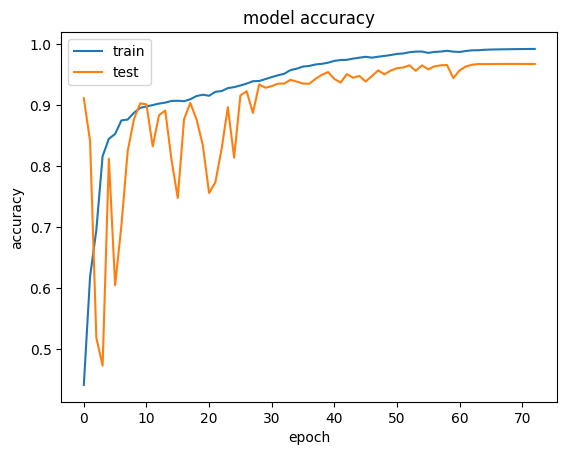

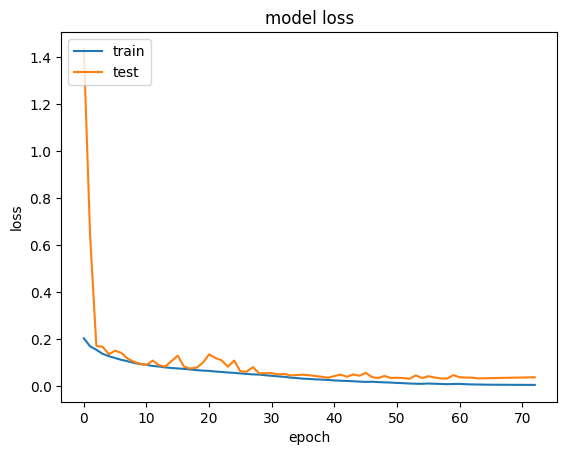

In [ ]:
# summarize history for accuracy
plt.plot(unet_history_df['accuracy'])
plt.plot(unet_history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(unet_history_df['loss'])
plt.plot(unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Res-UNET

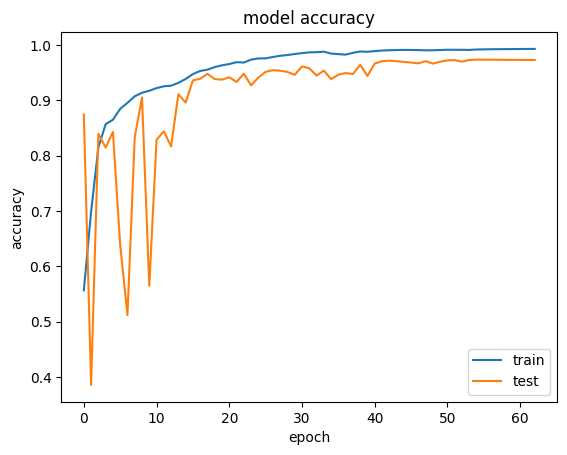

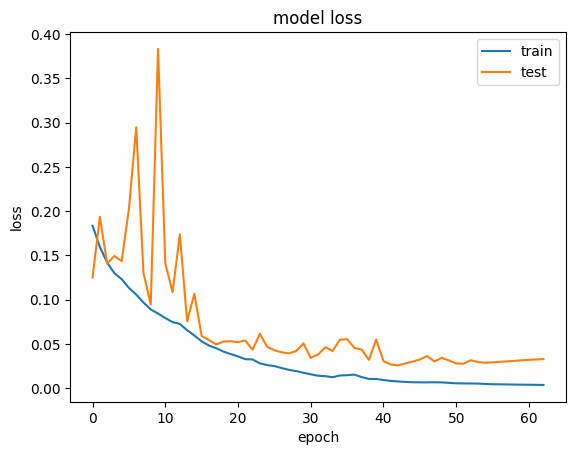

In [ ]:
# summarize history for accuracy
plt.plot(res_unet_history_df['accuracy'])
plt.plot(res_unet_history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(res_unet_history_df['loss'])
plt.plot(res_unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Att-Res-UNET

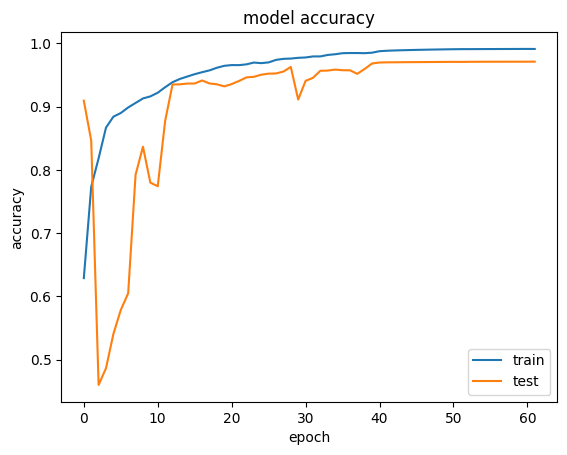

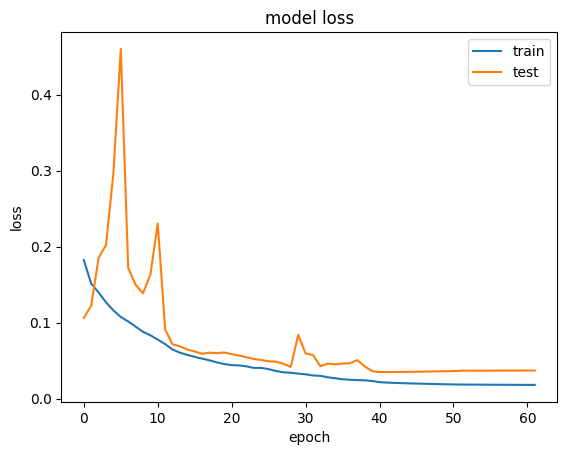

In [ ]:
# summarize history for accuracy
plt.plot(att_res_unet_history_df['accuracy'])
plt.plot(att_res_unet_history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(att_res_unet_history_df['loss'])
plt.plot(att_res_unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Together

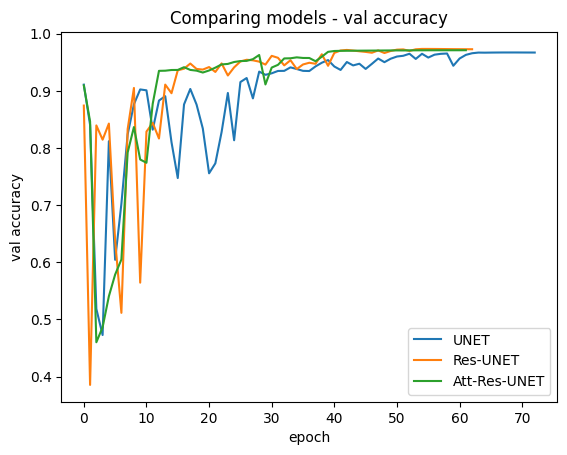

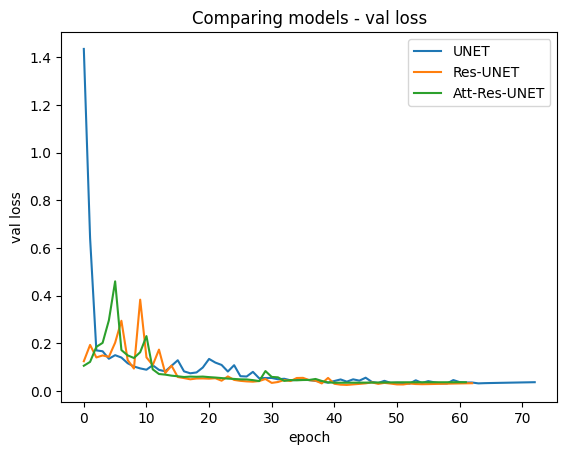

In [ ]:
# summarize history for accuracy
plt.plot(unet_history_df['val_accuracy'])
plt.plot(res_unet_history_df['val_accuracy'])
plt.plot(att_res_unet_history_df['val_accuracy'])

plt.title('Comparing models - val accuracy')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['UNET', 'Res-UNET', 'Att-Res-UNET'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(unet_history_df['val_loss'])
plt.plot(res_unet_history_df['val_loss'])
plt.plot(att_res_unet_history_df['val_loss'])

plt.title('Comparing models - val loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['UNET', 'Res-UNET', 'Att-Res-UNET'], loc='upper right')
plt.show()

## Visualise Results

Load Test Data

In [ ]:
def read_test_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return image

def read_test_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

In [ ]:
def get_dataset(x_path, y_path):
  X = np.empty((len(x_path), 256, 256, 3))
  y = np.empty((len(y_path), 256, 256, 1))
  for i, path in enumerate(x_path):
    image = read_test_image(x_path[i])
    mask = read_test_mask(y_path[i])
    X[i, ], y[i, ] = image, mask

  return X, y

In [ ]:
X_arr, y_arr = get_dataset(X_test, y_test)

In [ ]:
test_dataset = tf_dataset(X_test, y_test)

In [ ]:
batch_size = 8
test_steps=len(X_test) // batch_size

In [ ]:
unet_model = tf.keras.models.load_model(BASE_PATH + 'UNet_100epochs_B_focal.hdf5',custom_objects={'jacard_coef': jacard_coef})
res_unet_model = tf.keras.models.load_model(BASE_PATH + 'Res_UNet_100epochs_B_focal.hdf5', custom_objects={'jacard_coef': jacard_coef})
att_res_unet_model = tf.keras.models.load_model(BASE_PATH + 'Att_Res_UNet_100epochs_B_focal.hdf5', custom_objects={'jacard_coef': jacard_coef})

Evaluation Metric Functions

In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def cal_accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def cal_dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

Display Functions

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def display_confusion_matrix(Y_val, Y_pred):
    FP = len(np.where(Y_pred - Y_val  == 1)[0])
    FN = len(np.where(Y_pred - Y_val  == -1)[0])
    TP = len(np.where(Y_pred + Y_val ==2)[0])
    TN = len(np.where(Y_pred + Y_val == 0)[0])
    print("TN: ", TN, "FP: ", FP )
    print("FN: ", FN, "TP: ", TP)
    # cmat = [[FP, TN], [TP, FN]]
    cmat = [[TN, FP], [FN, TP]]

    plt.figure(figsize = (6,6))
    sns.heatmap(cmat, cmap=ListedColormap(['white']), annot=True, square=True, fmt='d', linewidth=2.,linecolor='black', cbar=False)
    # sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()

def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(cal_accuracy(mask, pred))
        metrics['Dice'].append(cal_dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

def display_metrics(mask, pred):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    metrics['Precision'].append(precision_score_(mask, pred))
    metrics['Recall'].append(recall_score_(mask, pred))
    metrics['Accuracy'].append(cal_accuracy(mask, pred))
    metrics['Dice'].append(cal_dice_coef(mask, pred))
    metrics['IoU'].append(iou(mask, pred))

    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 48s 19s/step - loss: 0.0387 - accuracy: 0.9681 - jacard_coef: 0.2802
Loss is 3.87%
Accuracy is 96.81%
Jaccard is 28.02%


In [ ]:
y_predict = unet_model.predict(X_arr)

2/2 [==============================] - 44s 18s/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

,Precision,Recall,Accuracy,Dice,IoU
0,0.913,0.733,0.97,0.813,0.686


TN:  3675678 FP:  21865
FN:  89465 TP:  257791


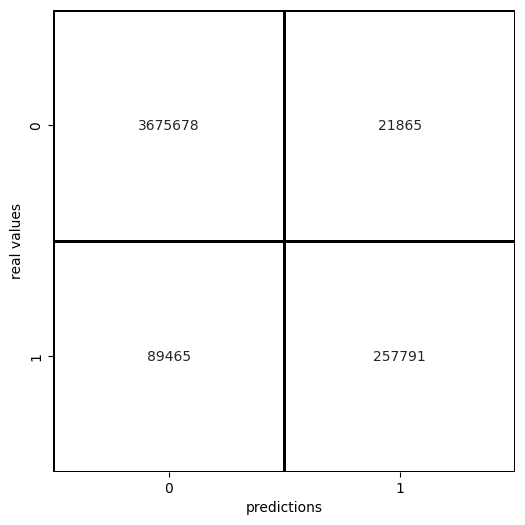

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

Res-UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = res_unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 7s 3s/step - loss: 0.0369 - accuracy: 0.9716 - jacard_coef: 0.3131
Loss is 3.69%
Accuracy is 97.16%
Jaccard is 31.31%


In [ ]:
y_predict = res_unet_model.predict(X_arr)

2/2 [==============================] - 7s 3s/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

,Precision,Recall,Accuracy,Dice,IoU
0,0.925,0.766,0.974,0.838,0.721


Confusion Matrix

TN:  3678689 FP:  18854
FN:  78148 TP:  269108


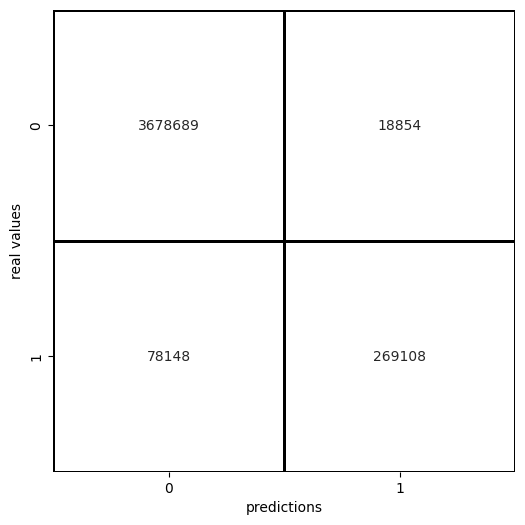

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

Attention Res-UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = att_res_unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 10s 4s/step - loss: 0.0394 - accuracy: 0.9696 - jacard_coef: 0.2162
Loss is 3.94%
Accuracy is 96.96%
Jaccard is 21.62%


In [ ]:
y_predict = att_res_unet_model.predict(X_arr)

2/2 [==============================] - 10s 4s/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

,Precision,Recall,Accuracy,Dice,IoU
0,0.881,0.788,0.972,0.832,0.712


Confusion Matrix

TN:  3663245 FP:  34298
FN:  70717 TP:  276539


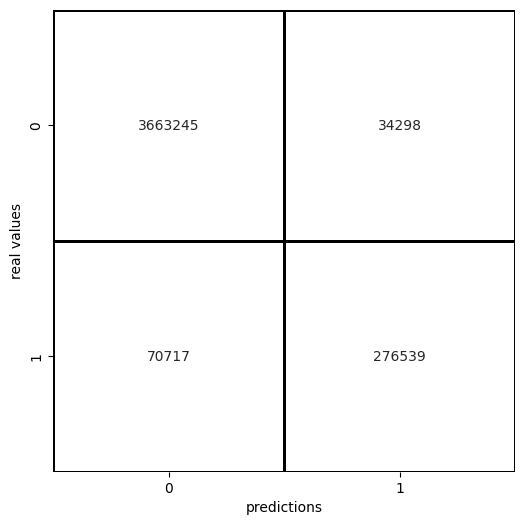

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

### Visualise and compare all models results

In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, image_path in enumerate(X_test):
    # Load the image
    img_path = image_path
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    # image = image / 255.0
    img_vis = io.imread(img_path)
    img_vis = cv2.resize(img_vis, (256, 256))
    img_vis = np.array(img_vis, dtype=np.float64)
    img_vis = img_vis / 255.0
    img = img / 255.0
    # img -= img.mean()
    # img /= img.std()

    # img = read_image(img_path)

    # Load the original mask
    orig_mask_path = y_test[index]
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # orig_mask = read_mask(orig_mask_path)

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    unet_predict = unet_model.predict(X)
    unet_pred_mask = np.array(unet_predict).squeeze().round()

    res_unet_predict = res_unet_model.predict(X)
    res_unet_pred_mask = np.array(res_unet_predict).squeeze().round()

    att_res_unet_predict = att_res_unet_model.predict(X)
    att_res_unet_pred_mask = np.array(att_res_unet_predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))
    # img = (img * 255).astype(np.uint8)
    plt.subplot(1, 5, 1)
    plt.imshow(img_vis)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(unet_pred_mask, cmap='gray')
    plt.title('Unet Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(res_unet_pred_mask, cmap='gray')
    plt.title('Res-Unet Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(att_res_unet_pred_mask, cmap='gray')
    plt.title('Att Res-Unet Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### UNET

In [ ]:
loss, accuracy, jaccard = unet_model.evaluate(test_dataset, steps = test_steps)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

7/7 [==============================] - 1s 192ms/step - loss: 0.0417 - accuracy: 0.9658 - jacard_coef: 0.2834
Loss is 4.17%
Accuracy is 96.58%
Jaccard is 28.34%


In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, image_path in enumerate(X_test[:20]):
    # Load the image
    img_path = image_path
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img = img / 255.0
    # img -= img.mean()
    # img /= img.std()

    # img = read_image(img_path)

    # Load the original mask
    orig_mask_path = y_test[index]
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # orig_mask = read_mask(orig_mask_path)

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Res-UNET

In [ ]:
from keras.models import load_model

# Load the entire model
resunet_model.load_weights(dataset_path + "RESUNet-segModel-weights.hdf5")

In [ ]:
loss, accuracy, jaccard = res_unet_model.evaluate(test_dataset, steps = test_steps)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

7/7 [==============================] - 2s 223ms/step - loss: 0.0397 - accuracy: 0.9696 - jacard_coef: 0.3168
Loss is 3.97%
Accuracy is 96.96%
Jaccard is 31.68%


In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, image_path in enumerate(X_test[:20]):
    # Load the image
    img_path = image_path
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img = img / 255.0
    # img -= img.mean()
    # img /= img.std()

    # img = read_image(img_path)

    # Load the original mask
    orig_mask_path = y_test[index]
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # orig_mask = read_mask(orig_mask_path)

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = res_unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Attention Res-UNET

In [ ]:
# Load the entire model
attention_unet.load_weights(dataset_path + "Attention-segModel-weights.hdf5")

In [ ]:
loss, accuracy, jaccard = att_res_unet_model.evaluate(test_dataset, steps = test_steps)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

7/7 [==============================] - 2s 257ms/step - loss: 0.0410 - accuracy: 0.9677 - jacard_coef: 0.2209
Loss is 4.10%
Accuracy is 96.77%
Jaccard is 22.09%


In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, image_path in enumerate(X_test[:20]):
    # Load the image
    img_path = image_path
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img = img / 255.0
    # img -= img.mean()
    # img /= img.std()

    # img = read_image(img_path)

    # Load the original mask
    orig_mask_path = y_test[index]
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # orig_mask = read_mask(orig_mask_path)

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = att_res_unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.